# Leakage - Gadolinium DCE

Use this notebook for single animals, otherwise run it in batch from **GLUT1_Analysis**

In [1]:
import os, sys, pathlib
import subprocess
import numpy as np
import pandas as pd

from imp import importlib
import fnmatch
import papermill as pm
from lmfit.models import ExpressionModel

mymodules = os.fspath(pathlib.Path.cwd().joinpath('../CustomModules'))
if mymodules not in sys.path:
    sys.path.append(mymodules)

import MRIhelperfunctions as h
import MRIhelperfunctions
from MRIhelperfunctions import Settings

import nibabel as nib
import matplotlib.pyplot as plt
%matplotlib inline  

In [2]:
importlib.reload(h)
import MRIhelperfunctions as h
from MRIhelperfunctions import Settings

In [3]:
# Default Parameters (to run script independently)
folders = {}
folders['raw'] = '/home/aic/BigHDD/MR_DATA/GLUT1/Rawdata'
folders['main'] = os.path.dirname(folders['raw'])
folders['analysis'] = '/home/aic/BigHDD/MR_DATA/GLUT1/Analysis'
folders['animal'] = '/home/aic/BigHDD/MR_DATA/GLUT1/Rawdata/20180607_133545_Glut1_2_6'
folders['excel'] = 'Animal_Scan_IDs.xlsx'


# animal = 'glut1_male1'
animal = 'glut1_f10wks3'

info = h.getinfo(folders)
info

,glut1_male1,glut1_male2,glut1_f10wks1,glut1_f10wks2,glut1_f10wks3,glut1_f10wks4,glut1_f10wks5,glut1_f10wks6,glut1_f8wks1,glut1_f8wks2,glut1_f8wks3,glut1_f8wks4,glut1_f8wks5,glut1_f8wks6,glut1_f8wks7,glut1_f6wks2,glut1_f6wks1
scan,,,,,,,,,,,,,,,,,
genotype,1,1,1,2,1,2,2,1,1,1,2,2,2,2,1,1,1
Gd DCE,6,8,6,5,5,8,5,5,7,5,6,6,8,8,6,5,5
Angio pre,8,9,7,6,6,9,6,6,8,6,9,8,9,9,8,6,6
Angio post,12,12,11,9,9,13,10,11,12,11,12,12,16,13,12,9,10
Endorem DCE,11,11,10,8,8,12,9,10,10,10,11,11,15,12,11,8,9
Diamox,15,14,13,11,13,15,12,13,15,13,16,17,20,16,14,11,13
folder,/home/aic/BigHDD/MR_DATA/GLUT1/Rawdata/2018060...,/home/aic/BigHDD/MR_DATA/GLUT1/Rawdata/2018060...,/home/aic/BigHDD/MR_DATA/GLUT1/Rawdata/2018060...,/home/aic/BigHDD/MR_DATA/GLUT1/Rawdata/2018060...,/home/aic/BigHDD/MR_DATA/GLUT1/Rawdata/2018060...,/home/aic/BigHDD/MR_DATA/GLUT1/Rawdata/2018060...,/home/aic/BigHDD/MR_DATA/GLUT1/Rawdata/2018060...,/home/aic/BigHDD/MR_DATA/GLUT1/Rawdata/2018060...,/home/aic/BigHDD/MR_DATA/GLUT1/Rawdata/2018061...,/home/aic/BigHDD/MR_DATA/GLUT1/Rawdata/2018061...,/home/aic/BigHDD/MR_DATA/GLUT1/Rawdata/2018061...,/home/aic/BigHDD/MR_DATA/GLUT1/Rawdata/2018061...,/home/aic/BigHDD/MR_DATA/GLUT1/Rawdata/2018061...,/home/aic/BigHDD/MR_DATA/GLUT1/Rawdata/2018061...,/home/aic/BigHDD/MR_DATA/GLUT1/Rawdata/2018061...,/home/aic/BigHDD/MR_DATA/GLUT1/Rawdata/2018061...,/home/aic/BigHDD/MR_DATA/GLUT1/Rawdata/2018061...


In [4]:
# additional Script specific parameters

baseline = 50  # <-- Time until contrast agent injection


try:
    info = pd.read_json(info)  #<-- dont run this line in single animal mode
except:
    pass
    
folders['template'] = os.path.join(folders['main'], 'Templates', 'EPI.nii' ) # from animal glut1_male1
folders['in'] = os.path.join(folders['analysis'], animal)
folders['out'] = os.path.join(folders['in'], 'Leakage')

if not os.path.exists(folders['out']):
    os.makedirs(folders['out'] )

In [5]:
scans={}
scans['number'] = int(info.loc['Gd DCE', animal])

scans['raw'] = os.path.join(folders['in'], f"X{scans['number']}P1.nii")


raw = nib.load(scans['raw'])
print(f'check if these dimensions make sense:  pre: {raw.shape}')

check if these dimensions make sense:  pre: (80, 80, 300)


## Coregistration

In [6]:
scans['single'] = f"{folders['out']}/single_timepoint.nii"

# get single repetition
h.runAFNI(f"3dTcat -prefix {scans['single']} {scans['raw']}'[0]'")

scans['single_coreg'], scans['coreg'] = h.simple_coreg(folders['template'], scans['single'], scans['raw'], folders['out'])

3dTcat -prefix /home/aic/BigHDD/MR_DATA/GLUT1/Analysis/glut1_f10wks3/Leakage/single_timepoint.nii /home/aic/BigHDD/MR_DATA/GLUT1/Analysis/glut1_f10wks3/X5P1.nii'[0]'
3dAllineate -base /home/aic/BigHDD/MR_DATA/GLUT1/Templates/EPI.nii -source /home/aic/BigHDD/MR_DATA/GLUT1/Analysis/glut1_f10wks3/Leakage/single_timepoint.nii -prefix /home/aic/BigHDD/MR_DATA/GLUT1/Analysis/glut1_f10wks3/Leakage/A_coreg.nii -cost ls -zclip -interp quintic -final wsinc5 -twopass -twoblur 2 -fineblur 0.5 -nmatch 80% -conv 0.01 -1Dparam_save /home/aic/BigHDD/MR_DATA/GLUT1/Analysis/glut1_f10wks3/Leakage/1dparams.1D
3dAllineate -1Dparam_apply /home/aic/BigHDD/MR_DATA/GLUT1/Analysis/glut1_f10wks3/Leakage/1dparams.1D -source /home/aic/BigHDD/MR_DATA/GLUT1/Analysis/glut1_f10wks3/X5P1.nii -prefix /home/aic/BigHDD/MR_DATA/GLUT1/Analysis/glut1_f10wks3/Leakage/B_coreg.nii -cost ls -zclip -interp quintic -final wsinc5 -twopass -twoblur 2 -fineblur 0.5 -nmatch 80% -conv 0.01 -master /home/aic/BigHDD/MR_DATA/GLUT1/Templat

In [8]:
img = nib.load(scans['coreg'])
data = img.get_fdata()
hdr = img.header
print(hdr)

dimensions = Settings()

dimensions.affine=np.zeros((4,4))

dimensions.x = hdr['dim'][1]
dimensions.y = hdr['dim'][2]
dimensions.z = 1 # exception here, because repetitions are in z dimension

dimensions.affine[0,:] = hdr['srow_x']
dimensions.affine[1,:] = hdr['srow_y']
dimensions.affine[2,:] = hdr['srow_z']

dimensions.time = hdr['pixdim'][3] # normally Z, here its time


data_reshaped = data.reshape(-1, data.shape[-1]) # we keep the time points, but put flatten all voxels in 1D.

<class 'nibabel.nifti1.Nifti1Header'> object, endian='<'
sizeof_hdr      : 348
data_type       : b''
db_name         : b''
extents         : 0
session_error   : 0
regular         : b'r'
dim_info        : 0
dim             : [  3  80  80 300   1   1   1   1]
intent_p1       : 0.0
intent_p2       : 0.0
intent_p3       : 0.0
intent_code     : none
datatype        : float32
bitpix          : 32
slice_start     : 0
pixdim          : [1.   0.25 0.25 2.   0.   0.   0.   0.  ]
vox_offset      : 0.0
scl_slope       : nan
scl_inter       : nan
slice_end       : 0
slice_code      : unknown
xyzt_units      : 2
cal_max         : 0.0
cal_min         : 0.0
slice_duration  : 0.0
toffset         : 0.0
glmax           : 0
glmin           : 0
descrip         : b''
aux_file        : b''
qform_code      : scanner
sform_code      : scanner
quatern_b       : -0.70710677
quatern_c       : 0.0
quatern_d       : 0.0
qoffset_x       : -9.721977
qoffset_y       : -299.78116
qoffset_z       : 6.2221427
srow_x     

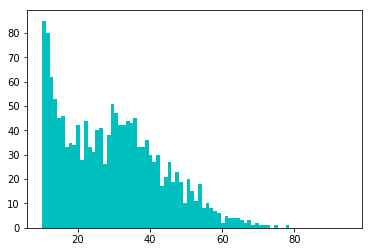

In [9]:
data_averaged = np.mean(data,axis=2)  # average time points

threshold = 10
# data[data <= threshold] = 0

plt.hist(data_averaged.flatten(), bins=80, color='c', range=(threshold, np.max(data)))
plt.show()

In [10]:
def prepare_signal(x):
    skip = False
    
    # mean pre-injection
    cutoff = 2 #initial cutoff and some safety margin before dip
    bsl_end = baseline - 5

    mean_pre = np.mean(x[cutoff:bsl_end]) 
    
#     if mean_pre >= np.mean(x[bsl_end:]):
#         return 0, 0, True
        
    
    # start searching from the minimum
    min_point = np.argmin(x[bsl_end:-50]) + bsl_end  # because some scans had zeros at the end
    max_point = np.argmax(x[min_point:]) + min_point
    max_val = np.max(x)

    # x0: start point for expenential curve fit (should be very close to 50 injection site usually)
    x0 = np.argmax( x[min_point:min_point+50] >= mean_pre ) + min_point
    
    # debugging
#     print(mean_pre)
#     print(min_point)
    
    try:
        # xend: until which timepoint to fit the exponential curve... should be at some steady state level before washout
        xend = int(np.argwhere(x[max_point:] < 0.95 * max_val)[0]) + max_point #first point where it drops below 95% of max
    except:
        # if it keeps increasing we use the maximum apparently?
        return x0, max_point, False
    
    if xend-x0 < 5:
        skip = True
    else:
        skip = False
            
    return (x0, xend, skip)

Below, just to play around. Function to be used is in file MRIhelperfunctions.py

Select cell, from menu above choose *Code* instead of *Markdown* to activate them.

# open in afni and check xyz coordinates. (0,0 is upper left)
_x = 65  # horizontal on image
_y = 21  # vertical on image

voxelnr = _x*80+_y  #(apparently x in afni is y here and vice versa)

x = data_reshaped[voxelnr,:]
# x = data_reshaped[3658,:]


plt.figure(figsize=(20,10))
plt.plot(x[0:],'ko')

x0, xend, skip = prepare_signal(x)
print('x0',x0)
print('xend',xend)
print('skip',skip)

# h.exp_fits(data_reshaped[voxel,:],x0, xend, dimensions.time)

x0, xend, skip = prepare_signal(x)
print('x0',x0)
print('xend',xend)
print('skip',skip)


# model = ExpressionModel('B*(1 - exp(-ktrans * (x)))')
model = ExpressionModel('B*(1 - exp(-ktrans * (x))) * exp(-w * x)') # with washout


params = model.make_params()
params['ktrans'].set(value=0.001,min=0.0001, max=0.1)
params['B'].set(value=0.1, min=0.01, max=50)
params['w'].set(value=0.0001,min=0, max=0.001)


signal = x[x0:xend]-x[x0]

time = np.arange(0, signal.size, 1) * dimensions.time

result = model.fit(signal, params, x=time)

# slope = result.best_values['B']*result.best_values['ktrans']  #derivative of model function at point x=0

integral = np.sum(result.best_fit)


print(result.fit_report())
plt.figure(figsize=[15,10])
plt.plot(time, signal)
plt.plot(time, result.best_fit)

In [ ]:
# run fit over all voxels

threshold = 10 # see histogram above, to speed up analysis skip low signal (outside brain) voxels

n_voxel = data_reshaped.shape[0]
maximum = np.zeros(n_voxel)

for voxel in range(n_voxel):
    if np.mean(data_reshaped[voxel,:]) > threshold:
        x0, xend, skip = prepare_signal(data_reshaped[voxel,:])
        if skip:
            print('skipping: ',voxel)
            maximum[voxel] = 0
        else:
            try:
                a, b, maximum[voxel], d, e, f = h.exp_fits(data_reshaped[voxel,:],x0, xend, dimensions.time)
            except:
                maximum[voxel] = 0
                print(f'unknown error in voxel {voxel}')
    else:
        maximum[voxel] = 0

skipping:  1147
skipping:  1546
skipping:  2028
skipping:  2108
skipping:  2188


In [47]:
# save Nifti Files
scans={}
scans['Leakage_max'] = h.save_nifti(maximum, dimensions, folders, animal, 'Leakage_max')

# save directories papermill for the main notebook:
pm.record("Leakage_max", scans['Leakage_max'])